In [1]:
# Python dependencies 
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize  import curve_fit
from scipy.special   import erf, betainc, gamma
from scipy           import asarray as ar,exp
from numpy.random    import uniform
from scipy           import stats
from scipy.integrate import simps


# External Dependencies
from ROOT import TFile, TTree

# My Dependencies
from Data      import *
from Helper    import *

/home/jcordero/anaconda3/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.3 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [9]:
#path    = "/home/jcordero/CMS/data_2016/SMP_ZG/mumugm/Files/JamesMatch/Full_new/"
#figpath = "/home/jcordero/CMS/data_2016/SMP_ZG/mumugm/figs/JamesMatch/Full_new/"

selection = 'mumug'
#selection = 'elelg'
#path    = "/home/jcordero/CMS/data_2016/SMP_ZG/Files/"+selection+"/"
path    = "/home/jcordero/CMS/data_2016/SMP_ZG/Files/"+selection+"/WithMuonVeto/"
#path    = "/home/jcordero/CMS/data_2016/SMP_ZG/Files/"+selection+"/HZG/"
figpath = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/"+selection+"/"

Help    = Helper()



In [10]:
# --------------------------------------
#  Data
# ---------------------------------------
#run = ['B','C','D','E','F','G','H']
#MuonData = [Data(path+"Data/","muon_2016",trigger = r,data=True) for r in run]
run = ['B','C','D','E','F','G','H']
if selection   == 'mumug':
    DoubleLepton = [Data(path+"DoubleMuon/","DoubleMuon_2016",trigger = r,data=True) for r in run]
elif selection == 'elelg':
    DoubleLepton = [Data(path+"DoubleEG/","DoubleEG_2016",trigger = r,data=True) for r in run]

trigger = "_v"

# ---------------------------------------
# Signal
# ---------------------------------------
ZG = Data(path + "ZG_ZToLL/", "ZG_ZToLL", trigger)
DYJets      = Data(path +      "DYJets/",     "DYJets", trigger)


print(' +++ Merging Data Samples')
Leptons = DoubleLepton[0] + DoubleLepton[1] + DoubleLepton[2] + DoubleLepton[3] + DoubleLepton[4] + DoubleLepton[5] + DoubleLepton[6]

----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2016/SMP_ZG/Files/mumug/WithMuonVeto/DoubleMuon/output_DoubleMuon_2016B.root
Opening    tree::   tree_DoubleMuon_2016B
-------------------------------------------------
----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2016/SMP_ZG/Files/mumug/WithMuonVeto/DoubleMuon/output_DoubleMuon_2016C.root
Opening    tree::   tree_DoubleMuon_2016C
-------------------------------------------------
----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2016/SMP_ZG/Files/mumug/WithMuonVeto/DoubleMuon/output_DoubleMuon_2016D.root
Opening    tree::   tree_DoubleMuon_2016D
-------------------------------------------------
----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2016/SMP_ZG/Files/mumug/WithMuonVeto/DoubleMuon/output_DoubleMuon_2016E.root
Opening    tree::   tree_DoubleMuon_2016E
----------

In [11]:
data        = [  DYJets,      ZG,    Leptons]
listSamples = ['DYJets',      'ZG', 'DoubleMuon']
legend      = ['DYJets',      'ZG', 'DoubleMuon']
colors      = [  'cyan',      'magenta',          'k']
dataFlag    = [   False,     False,         True]
combFlag    = [   False,     False,         True]

In [12]:
def ResetCuts():
    [d.ResetCuts() for d in data]
def STD_Cuts(phType='ISR'):
    #phType = 'ISR'
    #phType = 'FSR'
    phType = ''

    AddCuts = False
    #AddCuts = True

    mag = 1

    [d.ResetCuts() for d in data]
    #---------------------------- CUTS ------------------------------------ CUTS -----------------------
    # The proper cut
    #DYJets .AddCuts(np.array(DYJets.df.vetoDY)==False)


    for d in data:
        
        d.AddCuts(np.array(d.df.photonOnePt)>20)
        

        
        d.AddCuts(np.array(d.df.l1PhotonDR) > 0.4)
        d.AddCuts(np.array(d.df.l2PhotonDR) > 0.4)

        if phType == 'ISR':
            # 2 Body to get ISR
            d.AddCuts(np.array(d.df.llgM)+np.array(d.df.dileptonM) > 185)
        elif phType == 'FSR' :
            # 3 Body to get FSR
            d.AddCuts(np.array(d.df.llgM)+np.array(d.df.dileptonM) < 185)
        else: continue    

        #d.AddCuts(np.array(d.df.dileptonM) > 68)
        #d.AddCuts(np.array(d.df.llgM) > 91)

        #d.AddCuts(np.array(d.df.nJets)==0)
        #d.AddCuts(np.array(d.df.nJets)==1)
        #d.AddCuts(np.array(d.df.nJets)>1)
        #d.AddCuts(np.array(d.df.photonOneIph) > 0.6)

        # MVA CUT
        #d.AddCuts(np.array(d.df.photonOneMVA) > 0.5)
        #d.AddCuts(np.array(d.df.photonOneMVA)-5*np.array(d.df.photonOneHoverE) -0.6 > 0)

        d.AddCuts(np.array(d.df.leptonOneCharge) != np.array(d.df.leptonTwoCharge))

In [13]:
def FSRvsISR_phKin(Sample,ax,ptBin,photon):
    partS = ['photonOne']#,'photon1_EE','photon1_EB']
    varS = ['Eta','Phi','Pt']
    ranges = [[-3,3],[-3.5,3.5],[0,150]]
    dic = {v:r for v,r in zip(varS,ranges)}

    #fig = plt.figure(figsize=(15,6))
    n = 1
    for p in partS:
        for v in varS:
            plt.subplot(1,3,n)
            for label in photon:
                arg = np.array(Sample.GetWithCuts(p+v))

                plt.hist(arg[photon[label]],
                        range = dic[v],
                         bins = 30,
                         histtype = 'step',
                         linewidth = 1.5,
                         density = True,
                         label=label+' '+ptBin,
                         weights = Sample.GetWithCuts('weights'),
                        )
            ax.set_ylabel('# Counts')
            ax.set_xlabel(v)
            plt.legend()
            plt.grid(linestyle='--')
            #plt.title(p+'_'+v)
            n +=1
    
def FSRvsISR_phVars(Sample,
                    ax,ptBin,photon,
                    var,part,dim,dic):
    n = 1
    for p in part:
        for v in var:
            plt.subplot(dim[0],dim[1],n)
            for label in photon:
                arg = np.array(Sample.GetWithCuts(p+v))
                wei = Sample.GetWithCuts('weights')
                N = len(arg[photon[label]])
                plt.hist(arg[photon[label]],
                        range = dic[v],
                         histtype = 'step',
                         bins = 30,
                         label=label+' '+ptBin,
                         #weights = [1.0/N for _ in range(N)]
                         #weights = wei[photon[label]],
                         density = True,
                         #normed = True,
                        )
            plt.ylabel('# Counts')
            plt.xlabel(v)    
            plt.legend()
            plt.grid(linestyle='--')
            ax.set_title(p+'_'+v)
            n +=1

In [14]:
ptBin5s = {
        '20to25'  :[20,25],
        '25to30'  :[25,30],
        '30to35'  :[30,35],
        '35to40'  :[35,40],
        '40to45'  :[40,45],
        '45to50'  :[45,50],
        '50to55'  :[50,55],
        '55to60'  :[55,60],
        '60to65'  :[60,65],
        '65to70'  :[65,70],
        '70to75'  :[70,75],
        '75to85'  :[75,85],
        '85to95'  :[85,95],
        '95to110' :[95,110],
        }
ptBin10s = {
        '20to30'  :[20,30],
        '30to40'  :[30,40],
        '40to50'  :[40,50],
        '50to60'  :[50,60],
        '60to70'  :[60,70],
        '70to80'  :[70,80],
        '80to90'  :[80,90],
        '90to110' :[90,500],
        }
ptBinP = {
        '20to30'  :[20,30],
        '30to50'  :[30,50],
        '50to70'  :[50,70],
        '70to90'  :[70,90],
        '90to500' :[90,500],
        }

ptBin = ptBinP

-------- 20to30 ---------


/home/jcordero/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jcordero/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


-------- 30to50 ---------
-------- 50to70 ---------


/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


-------- 70to90 ---------
-------- 90to500 ---------


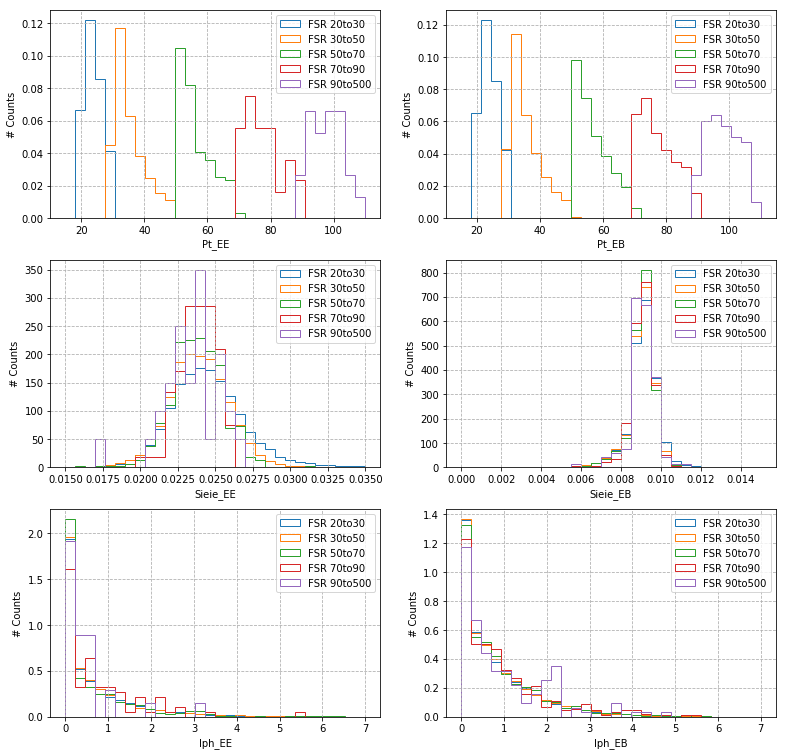

In [22]:
#Sample = DYJets
Sample = ZG

part = ['photonOne']

#--------------------------------------
#var = ['Ich','Ineu','Iph','Sieie','Sieie','HoverE','R9','MVA']
#ranges = [[0.1,3.2],[0.1,4.5],[0.1,5],[0,0.015],[0.015,0.04],[0.01,0.2],[0,1],[0,1]]
#dim = [4,3]
#-------------------------------------
var = ['Pt_EE','Pt_EB',
        'Sieie_EE','Sieie_EB',
       'Iph_EE','Iph_EB']
ranges = [
            [15,110],[15,110],
            [0.015,0.035],[0,0.015],
            [0,7],[0,7],
        ]
dim = [3,2]
#------------------------------------
#var = ['Sieie','Sieie_EE','Sieie_EB',
#        'Iph','Iph_EE','Iph_EB']
#ranges = [[0,0.035],[0.015,0.035],[0,0.015],
#          [0,7],[0,7],[0,7]]
#dim = [2,3]
#------------------------------------

dic = {v:r for v,r in zip(var,ranges)}



    
Joined = True
#Joined = False

if Joined:
    fig = plt.figure(figsize=(13,13))
    ax = plt.gca()
for i in ptBin:
    print('--------',i,'---------')
    STD_Cuts(phType='')
    for d in data:
        d.AddCuts(np.logical_and(d.df.photonOnePt > ptBin[i][0],
                                 d.df.photonOnePt < ptBin[i][1]))
        
    M2,M3 = Sample.GetWithCuts('dileptonM'),Sample.GetWithCuts('llgM')

    photon ={
            #'ISR':M2+M3 > 185,
            'FSR':M2+M3 < 185,
            #'': M2>-10
            }
    if not Joined:
        fig = plt.figure(figsize=(13,13))
        ax = plt.gca()
    FSRvsISR_phVars(Sample,ax,i,photon,var,part,dim,dic)
    #FSRvsISR_phKin(i,photon)
    if not Joined:
        fig.savefig(figpath+'Stacked/ISR_FSR_'+i+'.png')
        plt.show()
if Joined:
    fig.savefig(figpath+'Stacked/ISR_FSR.png')
    plt.show()        

-------- 20to30 ---------
-------- 30to50 ---------


/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


-------- 50to70 ---------
-------- 70to90 ---------
-------- 90to500 ---------


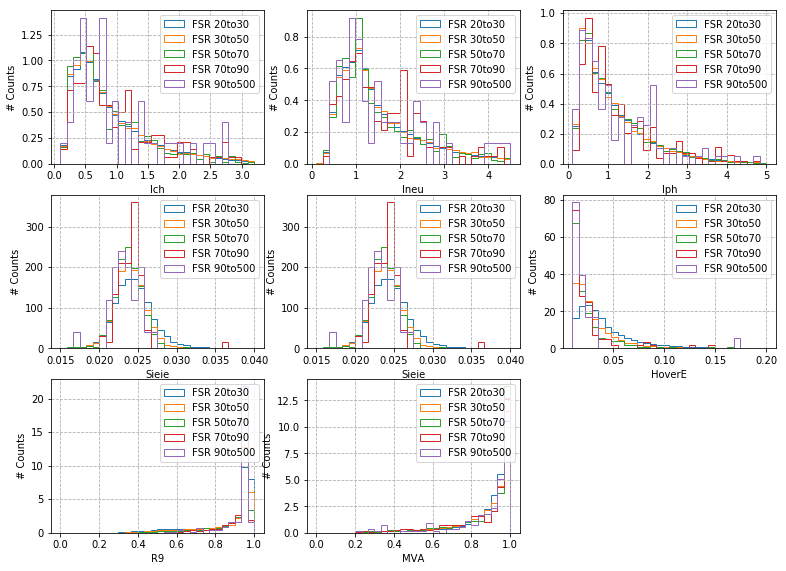

In [16]:
#Sample = DYJets
Sample = ZG

part = ['photonOne']

#--------------------------------------
var = ['Ich','Ineu','Iph','Sieie','Sieie','HoverE','R9','MVA']
ranges = [[0.1,3.2],[0.1,4.5],[0.1,5],[0,0.015],[0.015,0.04],[0.01,0.2],[0,1],[0,1]]
dim = [4,3]
#-------------------------------------
#var = ['Pt_EE','Pt_EB',
#        'Sieie_EE','Sieie_EB',
#       'Iph_EE','Iph_EB']
#ranges = [
#            [15,110],[15,110],
#            [0.015,0.035],[0,0.015],
#            [0,7],[0,7],
#        ]
#dim = [3,2]
#------------------------------------
#var = ['Sieie','Sieie_EE','Sieie_EB',
#        'Iph','Iph_EE','Iph_EB']
#ranges = [[0,0.035],[0.015,0.035],[0,0.015],
#          [0,7],[0,7],[0,7]]
#------------------------------------

dic = {v:r for v,r in zip(var,ranges)}



    
Joined = True

if Joined:
    fig = plt.figure(figsize=(13,13))
    ax = plt.gca()
for i in ptBin:
    print('--------',i,'---------')
    STD_Cuts(phType='')
    for d in data:
        d.AddCuts(np.logical_and(d.df.photonOnePt > ptBin[i][0],
                                 d.df.photonOnePt < ptBin[i][1]))
        
    M2,M3 = Sample.GetWithCuts('dileptonM'),Sample.GetWithCuts('llgM')

    photon ={
            #'ISR':M2+M3 > 185,
            'FSR':M2+M3 < 185,
            #'': M2>-10
            }
    if not Joined:
        fig = plt.figure(figsize=(13,13))
        ax = plt.gca()
    FSRvsISR_phVars(Sample,ax,i,photon,var,part,dim,dic)
    #FSRvsISR_phKin(i,photon)
    if not Joined:
        fig.savefig(figpath+'Stacked/ISR_FSR_'+ptBin+'.png')
        plt.show()
if Joined:
    fig.savefig(figpath+'Stacked/ISR_FSR.png')
    plt.show()        

-------- 20to30 ---------
-------- 30to50 ---------


/home/jcordero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


-------- 50to70 ---------
-------- 70to90 ---------
-------- 90to500 ---------


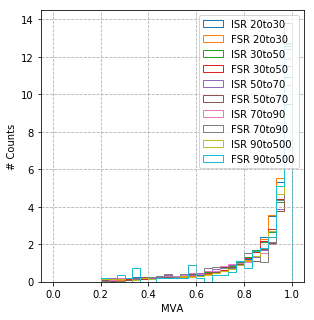

In [17]:
#Sample = DYJets
Sample = ZG

part = ['photonOne']

#--------------------------------------
#var = ['Ich','Ineu','Iph','Sieie','Sieie','HoverE','R9','MVA']
#ranges = [[0.1,3.2],[0.1,4.5],[0.1,5],[0,0.015],[0.015,0.04],[0.01,0.2],[0,1],[0,1]]
#dim = [4,3]
#-------------------------------------
#var = ['Pt_EE','Pt_EB',
#        'Sieie_EE','Sieie_EB',
#       'Iph_EE','Iph_EB']
#ranges = [
#            [15,110],[15,110],
#            [0.015,0.035],[0,0.015],
#            [0,7],[0,7],
#        ]
#dim = [3,2]
#------------------------------------
#var = ['Sieie','Sieie_EE','Sieie_EB',
#        'Iph','Iph_EE','Iph_EB']
#ranges = [[0,0.035],[0.015,0.035],[0,0.015],
#          [0,7],[0,7],[0,7]]
#------------------------------------
var = ['MVA']
ranges = [[0,1]]
dim = [1,3]
#------------------------------------

dic = {v:r for v,r in zip(var,ranges)}



    
Joined = True

if Joined:
    fig = plt.figure(figsize=(16,5))
    ax = plt.gca()
for i in ptBin:
    print('--------',i,'---------')
    STD_Cuts(phType='')
    for d in data:
        d.AddCuts(np.logical_and(d.df.photonOnePt > ptBin[i][0],
                                 d.df.photonOnePt < ptBin[i][1]))
        
    M2,M3 = Sample.GetWithCuts('dileptonM'),Sample.GetWithCuts('llgM')

    photon ={
            'ISR':M2+M3 > 185,
            'FSR':M2+M3 < 185,
            #'': M2>-10
            }
    if not Joined:
        fig = plt.figure(figsize=(13,13))
        ax = plt.gca()
    FSRvsISR_phVars(Sample,ax,i,photon,var,part,dim,dic)
    #FSRvsISR_phKin(i,photon)
    if not Joined:
        fig.savefig(figpath+'Stacked/ISR_FSR_'+ptBin+'.png')
        plt.show()
if Joined:
    fig.savefig(figpath+'Stacked/ISR_FSR.png')
    plt.show()        